# Sample solutions

https://www.nature.com/articles/s41467-019-13056-x

In [1]:
%matplotlib inline
%load_ext memory_profiler
import numpy as np
from scipy import sparse
import pandas as pd
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE, MDS, Isomap
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import time
import pandas as pd
import pickle
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from yellowbrick.cluster import SilhouetteVisualizer
import matplotlib as mpl
from yellowbrick.style import rcmod
from scipy.stats import spearmanr
from memory_profiler import profile

In /Users/jacob/opt/anaconda3/envs/6.86x/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/jacob/opt/anaconda3/envs/6.86x/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/jacob/opt/anaconda3/envs/6.86x/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /Users/jacob/opt/anaconda3/envs/6.86x/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.


In [2]:
# Yellowbrick changes the plotting settings, reset to default here
rcmod.reset_orig()

/Users/jacob/opt/anaconda3/envs/6.86x/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The animation.avconv_args rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/Users/jacob/opt/anaconda3/envs/6.86x/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The animation.avconv_path rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/Users/jacob/opt/anaconda3/envs/6.86x/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The animation.html_args rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/Users/jacob/opt/anaconda3/envs/6.86x/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The keymap.all_axes rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/Users/jacob/opt/anacond

# Problem 1

1. Load the data

In [3]:
X = np.load("../data/p1/X.npy")
y = np.load("../data/p1/y.npy")

In [4]:
# 511 cells, 45768 genes
print(X.shape)

(511, 45768)


In [5]:
# Largest entry of first column
np.max(X[:,0])

11.941397591320595

2. Log transform

In [6]:
# Log 
X_log = np.log2(X + 1)

In [7]:
# Largest entry of first column
print(np.max(X_log[:,0]))

3.6939215228197613


3. Full PCA, raw vs transformed data

In [8]:
%%timeit -n 1 -r 1
%%memit -r 1
pca = PCA().fit(X)
pca_log = PCA().fit(X_log)

peak memory: 1304.34 MiB, increment: 797.02 MiB
5.54 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [9]:
# A = np.array([1, 1, 0, 0, 0, 1, 1, 0, 0]).reshape(3, 3)
# A2 = A@A
# print(A2)

# A3 = A2@A
# print(A3)

In [10]:
# Percentage of variance explained by first component
print("First component raw:", pca.explained_variance_ratio_[0])
print(pca.explained_variance_ratio_.shape)
print("First component log:", pca_log.explained_variance_ratio_[0])
print(pca.explained_variance_ratio_.shape)

#print(pca.components_.shape)

First component raw: 0.4277967098357267
(511,)
First component log: 0.13887564870826197
(511,)


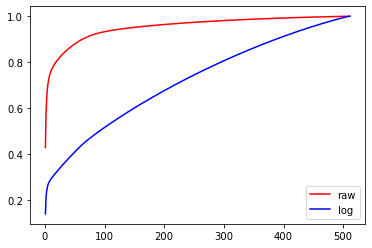

In [11]:
# Cumulative variance explained plots
plt.plot(range(1, X.shape[0]+1), np.cumsum(pca.explained_variance_ratio_), color="red", label="raw")
plt.plot(range(1, X.shape[0]+1), np.cumsum(pca_log.explained_variance_ratio_), color="blue", label="log")
plt.legend()
plt.show()

In [12]:
# 85% variance cutoffs
print("Raw:", np.where(np.cumsum(pca.explained_variance_ratio_) >= .85)[0][0] + 1)
#print(np.where(np.cumsum(pca.explained_variance_ratio_) >= .85))
print("Log:", np.where(np.cumsum(pca_log.explained_variance_ratio_) >= .85)[0][0] + 1)

Raw: 36
Log: 339


Remember that we want to find genes that can differentiate between cells, even if the genes are not expressed in many cells and/or have low levels of expression. For example, if a particular gene has $0$ expression for $80$ cells and $0.2$ expression for $20$ cells, that would contribute much less to the variance than a gene with $0$ expression for $50$ cells and $0.8$ expression for $50$ cells. While the latter gene might just differentiate between neuron vs non-neuron (for example),  the former gene might differentiate between specific cell types.  But the variances differ greatly and we don't want to make the conclusion that the latter gene is sufficient for explaining the variation between cells in the data.

4. Plotting without visualization techniques

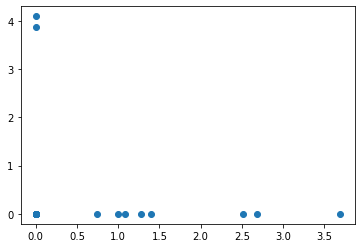

In [13]:
# Nothing informative!
plt.scatter(X_log[:,0],X_log[:,1])

5. PCA visualization

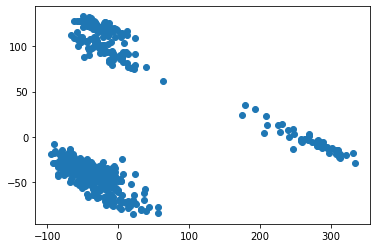

In [14]:
# Three visually distinct clusters. Could potentially argue for 4 or 5 as well, but these are not well-separated

# print(X_log.shape)
# print(pca_log)
z = pca_log.transform(X_log)
# print(z.shape)
# print(z[:6, :])
# print(z[:, 0])
plt.scatter(z[:,0],z[:,1])

6. MDS (sklearn version is nonlinear)

2139862468.9563172


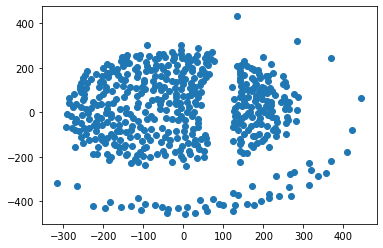

In [15]:
# Since there is randomization in the initial state, run this multiple times 
# and use the result with the best objective function value.  
# (Also be aware that some initializations can give you suboptimal local minima for both MDS and T-SNE algorithms). 
#We still see 3 distinct clusters.  
mds_class=MDS(n_components=2)
mds=mds_class.fit_transform(X_log)
print(mds_class.stress_)
stress = mds_class.stress_
plt.scatter(mds[:,0],mds[:,1])

In [16]:
# ## Manual calculus of sklearn stress
# DE = euclidean_distances(points)
# stress = 0.5 * numpy.sum((DE - data.values)**2)
# print("Manual calculus of sklearn stress :")
# print(stress)
# print("")

## Kruskal's stress (or stress formula 1)
stress1 = np.sqrt(stress / (0.5 * np.sum(X**2)))
print("Kruskal's Stress :")
print("[Poor > 0.2 > Fair > 0.1 > Good > 0.05 > Excellent > 0.025 > Perfect > 0.0]")
print(stress1)
print("")

Kruskal's Stress :
[Poor > 0.2 > Fair > 0.1 > Good > 0.05 > Excellent > 0.025 > Perfect > 0.0]
0.07846173798450895



7. T-SNE

0.4289248585700989


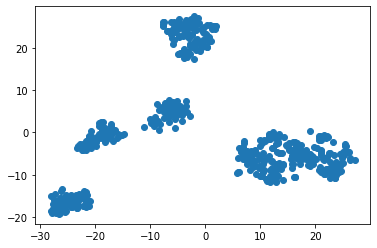

In [17]:
# Emergence of at least 5 clusters. 
# Since there is randomization in the initial state, 
# run this multiple times and use the result with the best objective function value.  
# (Also be aware that some initializations can give you suboptimal local minima for both MDS and T-SNE algorithms).

z_tsne_class = TSNE(n_components=2,perplexity=40)
z_tsne=z_tsne_class.fit_transform(z[:,0:50])
print(z_tsne_class.kl_divergence_)
plt.scatter(z_tsne[:,0],z_tsne[:,1])


8. K-Means: From the T-SNE plot (with the lowest KL-divergence), we can see the emergence of 5 clusters. 


In [18]:
# K-means with n=5, as decided from T-SNE plot above; 
# Run multiple times and explore settings to get the lowest inertia_, such aa:
# init='random', or random_state=0  
kmeans = KMeans(5, tol=1e-6) 
kmeans.fit(z[:,0:50])
print(kmeans.inertia_)
#print(kmeans.labels_)

5801585.180913831


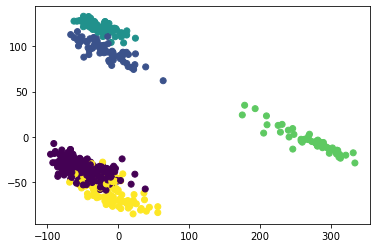

In [19]:
#PCA plot colored with K-means clusters
plt.scatter(z[:,0],z[:,1], c=kmeans.labels_)

2121573405.2928853


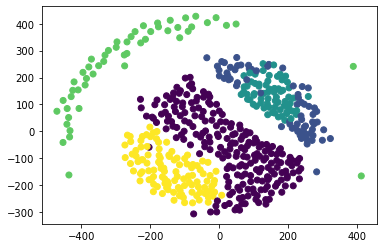

In [20]:
# MDS plot with 5 K-means clusters, on log-transformed data:
mds=mds_class.fit_transform(X_log)
print(mds_class.stress_)
plt.scatter(mds[:,0],mds[:,1],c=kmeans.labels_)

267018462.45737296


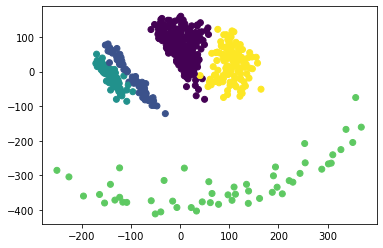

In [21]:
# Alternatively, MDS on first 50 PCS of log-transformed data
# colored with the 5 K-means clusters:
mds_class=MDS(n_components=2)
mds=mds_class.fit_transform(z[:,0:50])
print(mds_class.stress_)
plt.scatter(mds[:,0],mds[:,1],c=kmeans.labels_)

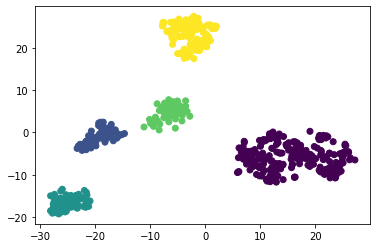

In [22]:
# T-SNE on first 50 PCS of log-transformed data,
# colored with 4 K-means clusters 

plt.scatter(z_tsne[:,0],z_tsne[:,1], c=kmeans.labels_)

9. Elbow method.

Num clusters 2 Inertia: 9520809.578745995
Num clusters 3 Inertia: 7257882.20119323
Num clusters 4 Inertia: 6202929.841899472
Num clusters 5 Inertia: 5801585.180913831
Num clusters 6 Inertia: 5619491.897568737
Num clusters 7 Inertia: 5366310.707419483
Num clusters 8 Inertia: 5236487.095470461
Num clusters 9 Inertia: 5177292.46229166


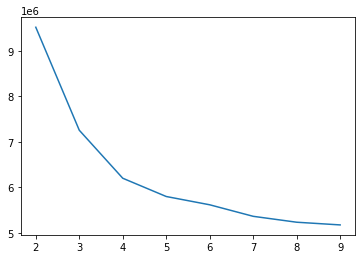

In [23]:
# Would select 3, 4, or 5 clusters
all_kmeans = [i for i in range(8)]
#print(all_kmeans)
for i in range(8):
    cur_kmeans = KMeans(i+2)
    cur_kmeans.fit(z[:,0:50])
    print("Num clusters", i+2, "Inertia:", cur_kmeans.inertia_)
    all_kmeans[i] = cur_kmeans
plt.plot([i+2 for i in range(8)], [all_kmeans[i].inertia_ for i in range(8)])

10. Hierarchical clustering: Dendrogram in R script

11. MDS on cluster means. Confirms 3 groups, one with 1 cluster and two with 2 clusters each. Accurate representation of distances - one cluster is far away from others, indicating a different type of cell. But T-SNE consistently puts it in the middle of the plot.

In [24]:
# MDS on kmeans cluster means

#print(X_log.shape[1])
cmeans = np.zeros((5,X_log.shape[1]))
for c in range(5):
    cmeans[c] = np.mean(X_log[np.where(kmeans.labels_==c)[0]],axis=0)
#print(X_log[np.where(kmeans.labels_==c)[0]].shape)
# print(kmeans.labels_.shape)
# print(X_log[np.where(kmeans.labels_==2)[0]])

breaking at iteration 159 with stress 6080.359402497777
breaking at iteration 105 with stress 6079.000766175071
breaking at iteration 152 with stress 6342.534144347234
breaking at iteration 63 with stress 6342.380978909566


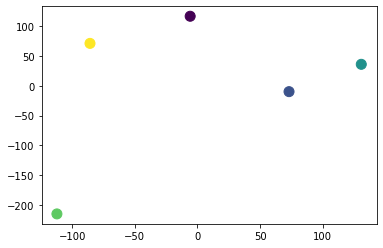

In [25]:
mds = MDS(n_components=2,verbose=1,eps=1e-5)
mds.fit(cmeans)
plt.scatter(mds.embedding_[:,0],mds.embedding_[:,1],c=[1,2,3,4,5],s=100)

In MDS, we see one group with 1 cluster mean and two groups with 2 cluster means each. MDS aim to respresent distances accurately.  The one cluster that far away from the other indicates a different type of cell.

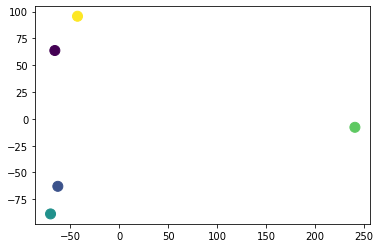

In [26]:
# PCA on cluster means
z_means = PCA(2).fit_transform(cmeans)
plt.scatter(z_means[:,0],z_means[:,1],c=[0,1,2,3,4],s=100)

Similarly, in PCA,  we again see one group with 1 cluster mean and two groups with 2 cluster means each. PCA is a linear projection, hence the distances in the PC directions are preserved.  The one cluster that far away from the other indicates a different type of cell.

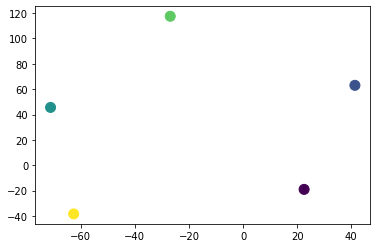

In [27]:
# Emergence of at least 5 clusters. 
z_means_tsne = TSNE(n_components=2,perplexity=40).fit_transform(cmeans)
plt.scatter(z_means_tsne[:,0],z_means_tsne[:,1],c=[0,1,2,3,4],s=100)

T-SNE does not represent distances accurately.  The hierarchical structure of the 5 clusters falling into 3 groups are lost.   (on the other hand, we saw that the 5 clusters are well separated.)

12. PCA/T-SNE on Raw Data

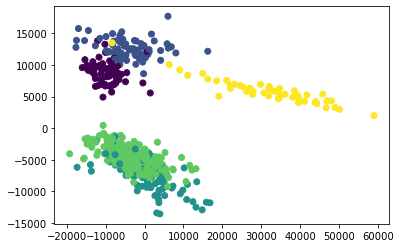

In [28]:
pca = PCA(50).fit(X)
z = pca.transform(X)
plt.scatter(z[:,0],z[:,1],c=y)

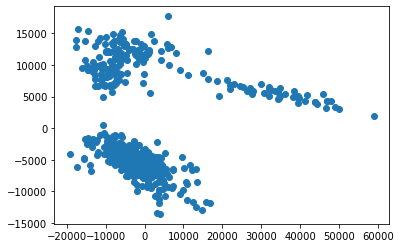

In [29]:
pca = PCA(50).fit(X)
z = pca.transform(X)
plt.scatter(z[:,0],z[:,1])

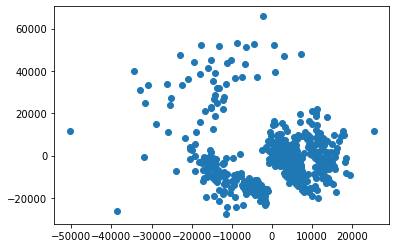

In [30]:
mds = MDS(n_components=2,verbose=1,eps=1e-5)
mds.fit(z[:,0:50])
plt.scatter(mds.embedding_[:,0],mds.embedding_[:,1])

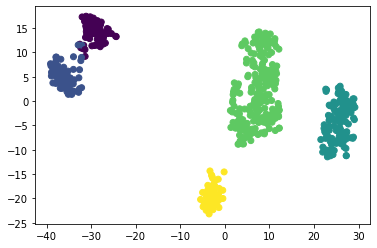

In [31]:
z_tsne = TSNE(n_components=2,perplexity=40).fit_transform(z[:,0:50])
plt.scatter(z_tsne[:,0],z_tsne[:,1],c=y)

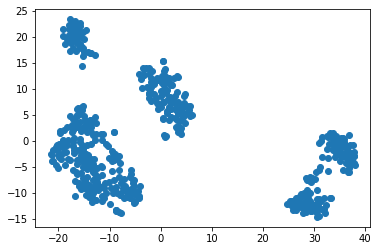

In [32]:
z_tsne = TSNE(n_components=2,perplexity=40).fit_transform(z[:,0:50])
plt.scatter(z_tsne[:,0],z_tsne[:,1])

The log transformed data produced more clearly defined clusters. This typically happens for this type of data.  